# Report

In [1]:
import torch
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from collections import deque

from agent import Agent
from model import QNetwork

## Initialize Unity Environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`


If the following code cell will be executed successfully a Unit Environment window will open.

In [2]:
# Initialize the environment
env = UnityEnvironment(file_name='Banana_Linux/Banana.x86', worker_id=1)

# Get default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Get state and action spaces
env_info = env.reset(train_mode=True)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size
print('State size:', state_size)
print('Action size:', action_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


State size: 37
Action size: 4


## Initialize agent

In [3]:
agent = Agent(state_size, action_size, hidden_layers=[256, 128, 64])

## Deep Q-Learning

Episode 100	Average Score: 0.85
Episode 200	Average Score: 4.83
Episode 300	Average Score: 7.93
Episode 400	Average Score: 11.03
Episode 500	Average Score: 12.62
Episode 513	Average Score: 13.02
Environment solved in 413 episodes!	Average Score: 13.02


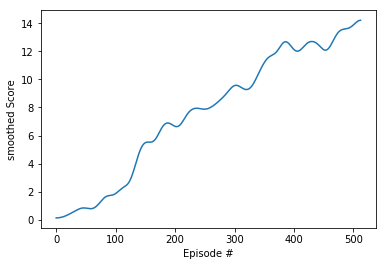

In [5]:
def dqn(env, brain_name, n_episodes=2000,
        max_steps=1000, epsilon_start=1.0,
        epsilon_end=.01, epsilon_decay=.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_stepsx_t (int): maximum number of timesteps per episode
        epsilon_start (float): starting value of epsilon, for epsilon-greedy action selection
        epsilon_end (float): minimum value of epsilon
        epsilon_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """

    scores = []
    scores_window = deque(maxlen=100)
    epsilon = epsilon_start
    for e in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break

        # Relative score
        scores_window.append(score)
        scores.append(score)

        # Update epsilon
        epsilon = max(epsilon_end, epsilon_decay*epsilon)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)), end="")
        if e % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e-100, np.mean(scores_window)))
            checkpoint = {'state_size': state_size,
                          'action_size': action_size,
                          'hidden_layers': [each.out_features for each in agent.qnet_local.hidden_layers],
                          'state_dict': agent.qnet_local.state_dict()}
            torch.save(checkpoint, 'checkpoint.pth')
            break
    return scores

scores = dqn(env, brain_name, n_episodes=2000)

fig = plt.figure()
ax = fig.add_subplot(111)
scores_smoothed = gaussian_filter1d(scores, sigma=10)
plt.plot(np.arange(len(scores)), scores_smoothed)
plt.ylabel('smoothed Score')
plt.xlabel('Episode #')
plt.show()

In [4]:
def load_checkpoints(filepath):
    checkpoint = torch.load(filepath)
    model = QNetwork(checkpoint['state_size'],
                     checkpoint['action_size'],
                     checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

def apply(env, brain_name, filepath):
    model = load_checkpoints(filepath)
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        state = torch.from_numpy(state).float().unsqueeze(0).to('cpu')
        model.eval()
        with torch.no_grad():
            action_values = model(state)
        action = np.argmax(action_values.cpu().data.numpy())
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        if done:
            break
    print('Score: {}'.format(score))
    
apply(env, brain_name, 'checkpoint.pth')

Score: 16.0


In [5]:
env.close()